# **Penting**
- Pastikan Anda melakukan Run All sebelum mengirimkan submission untuk memastikan seluruh cell berjalan dengan baik.
- Hapus simbol pagar (#) jika Anda menerapkan kriteria tambahan
- Biarkan simbol pagar (#) jika Anda tidak menerapkan kriteria tambahan

# **1. Import Library**
Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import joblib

# **2. Memuat Dataset**
Memuat dataset hasil clustering dari file CSV ke dalam variabel DataFrame.

In [99]:
url = "https://raw.githubusercontent.com/sirly82/predictive-analytics/refs/heads/main/diabetes.csv"
diabetes_df = pd.read_csv(url)

In [100]:
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [101]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [102]:
diabetes_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


(Opsional) Memuat Dataset dan Melakukan Exploratory Data Analysis (EDA) [Skilled]

**Biarkan kosong jika tidak menerapkan kriteria skilled**

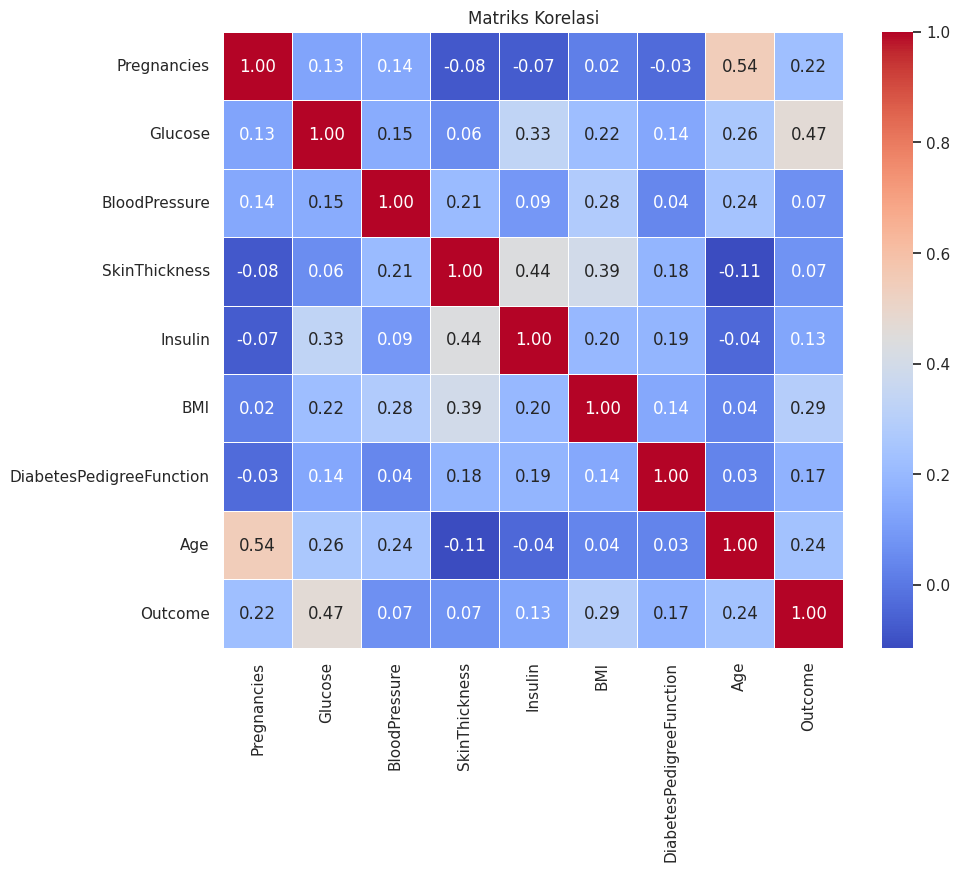

In [103]:
# Menampilkan korelasi antar fitur (Opsional Skilled 1)
corr_matrix = diabetes_df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriks Korelasi')
plt.show()

In [104]:
def plot_numeric_histograms(df):
  sns.set(style="whitegrid")

  num_cols = df.select_dtypes(include='number').columns

  total_plots = len(num_cols)
  n_cols = 3
  n_rows = math.ceil(total_plots / n_cols)

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
  axes = axes.flatten()

  for i, col in enumerate(num_cols):
    ax = axes[i]
    if col in num_cols:
      sns.histplot(data=df, x=col, bins=30, kde=True, ax=ax, color='skyblue')
      ax.set_title(f'Histogram: {col}', fontsize=12)
    else:
      unique_vals = df[col].nunique()
      if unique_vals <= 10:
        sns.countplot(data=df, x=col, order=df[col].value_counts().index, ax=ax, palette="Set2")
        ax.set_title(f'Countplot: {col}', fontsize=12)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
      else:
        sns.countplot(data=df, y=col, order=df[col].value_counts().index[:15], ax=ax, palette="Set3")
        ax.set_title(f'Top 15: {col}', fontsize=12)

    ax.grid(True)

  for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

  fig.suptitle("Distribusi Setiap Kolom", fontsize=16)
  plt.tight_layout(rect=[0, 0, 1, 0.97])
  plt.show()

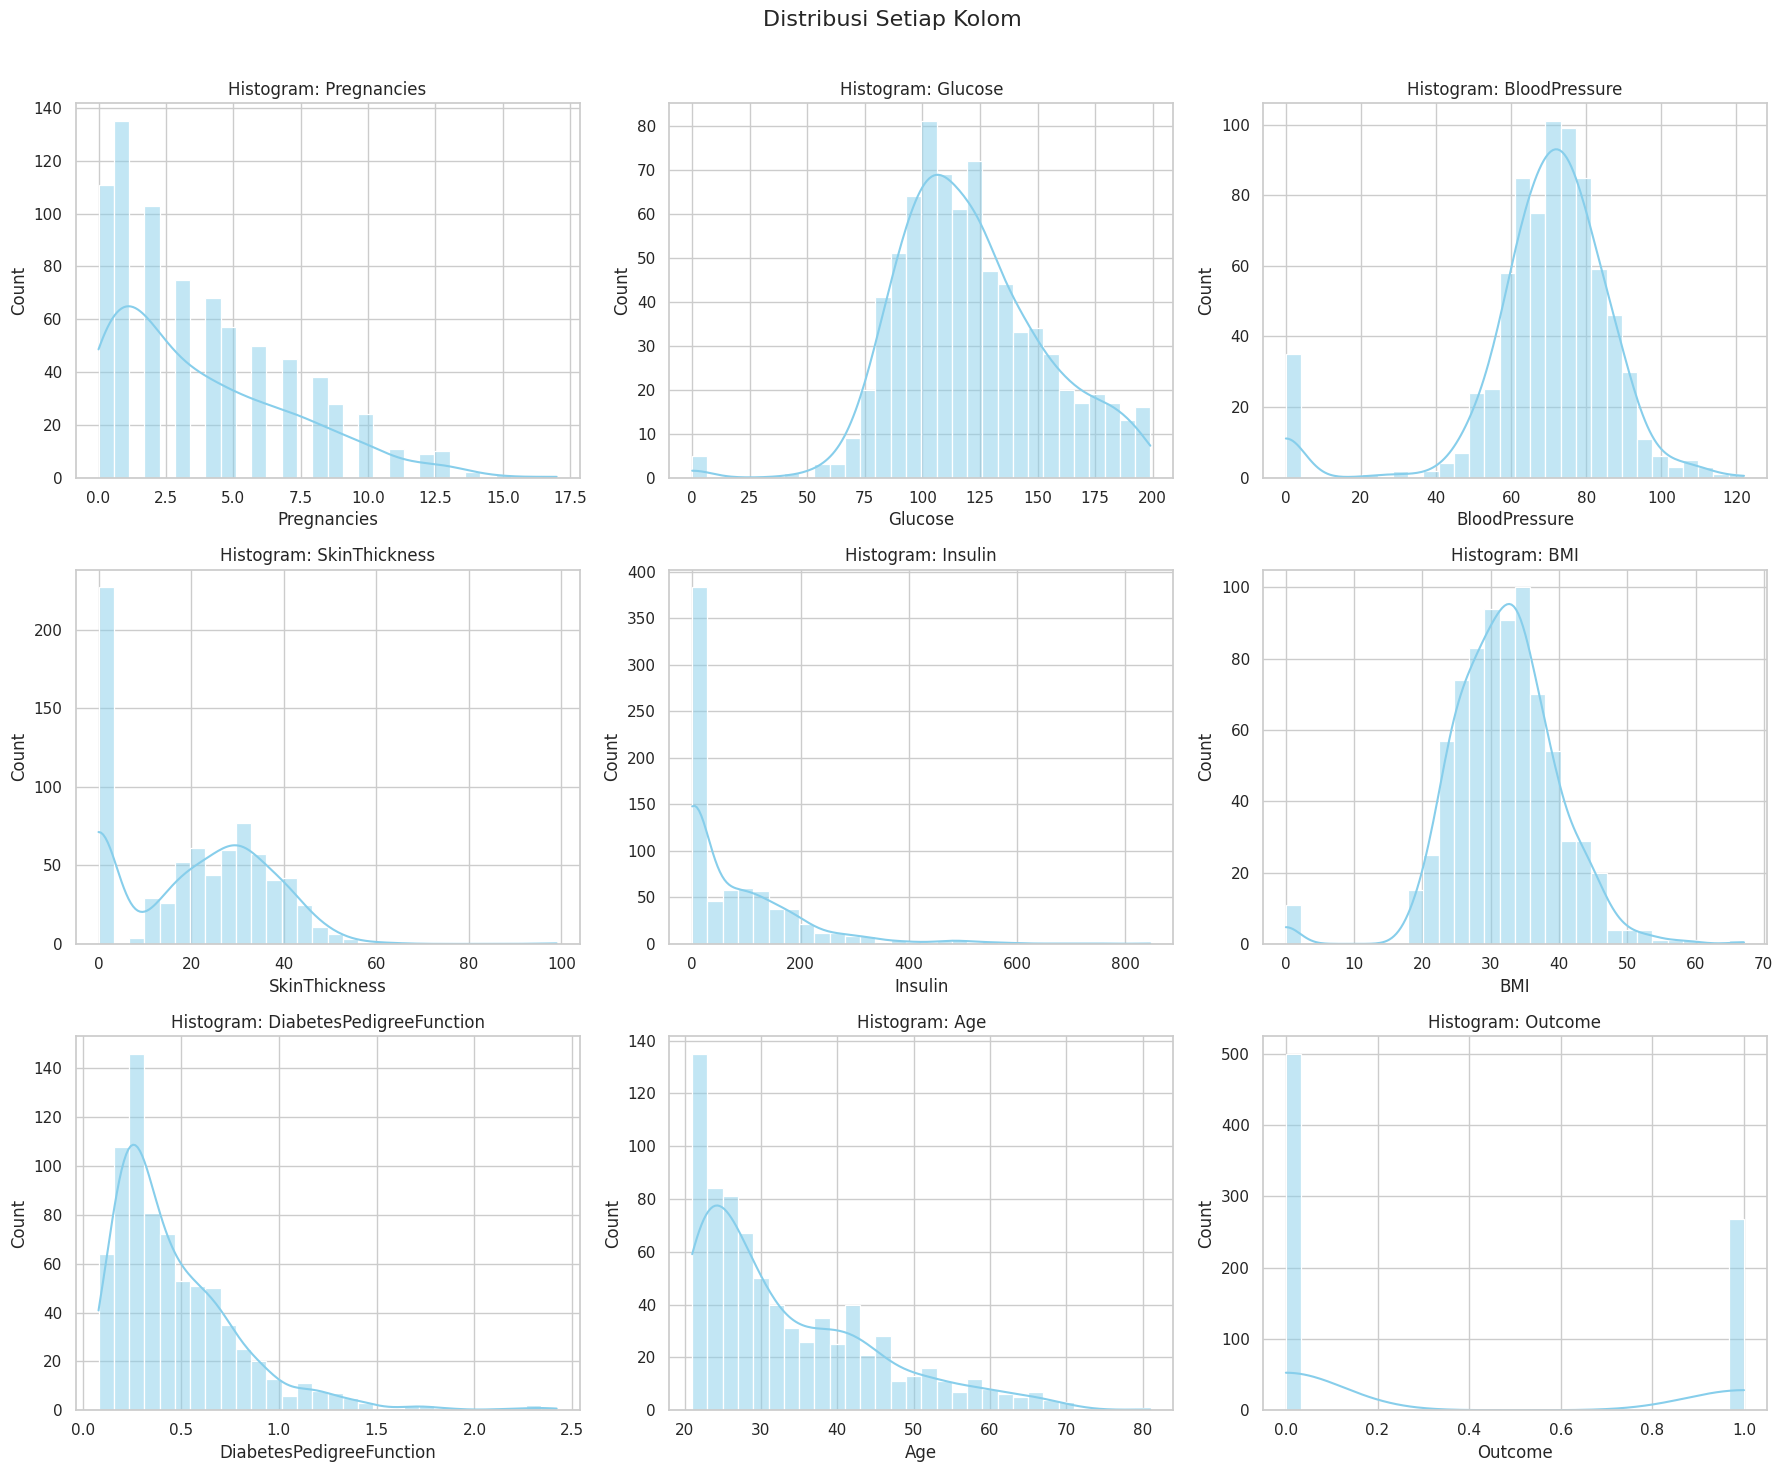

In [105]:
# Menampilkan histogram untuk semua kolom numerik (Opsional Skilled 1)
plot_numeric_histograms(diabetes_df)

# **3. Pembersihan dan Pra Pemrosesan Data**

In [106]:
diabetes_clean_df = diabetes_df.copy()

In [107]:
# Mengecek dataset menggunakan isnull().sum()
diabetes_clean_df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [108]:
# Mengecek dataset menggunakan duplicated().sum()
duplicates = diabetes_clean_df.duplicated()
print("Jumlah baris duplikat:", duplicates.sum())

Jumlah baris duplikat: 0


In [109]:
# Ganti nilai 0 menjadi NaN pada kolom yang tidak mungkin bernilai 0

cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
diabetes_df[cols_with_zero] = diabetes_df[cols_with_zero].replace(0, np.nan)

# Isi NaN dengan median
diabetes_df.fillna(diabetes_df.median(), inplace=True)

# **3. Data Splitting**
Tahap Data Splitting bertujuan untuk memisahkan dataset menjadi dua bagian: data latih (training set) dan data uji (test set).

In [110]:
scaler = StandardScaler()
X = diabetes_df.drop('Outcome', axis=1)
y = diabetes_df['Outcome']

X_scaled = scaler.fit_transform(X)

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# **4. Membangun Model Klasifikasi**
Setelah memilih algoritma klasifikasi yang sesuai, langkah selanjutnya adalah melatih model menggunakan data latih.

Berikut adalah rekomendasi tahapannya.
1. Menggunakan algoritma klasifikasi yaitu Logistic Regression
2. Latih model menggunakan data yang sudah dipisah.

## Logistic Regression

In [112]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

LogisticRegression()

In [136]:
y_pred_lr = model_lr.predict(X_test)

print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))

[[82 17]
 [21 34]]
              precision    recall  f1-score   support

           0       0.80      0.83      0.81        99
           1       0.67      0.62      0.64        55

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.73       154
weighted avg       0.75      0.75      0.75       154

Accuracy: 0.7532467532467533


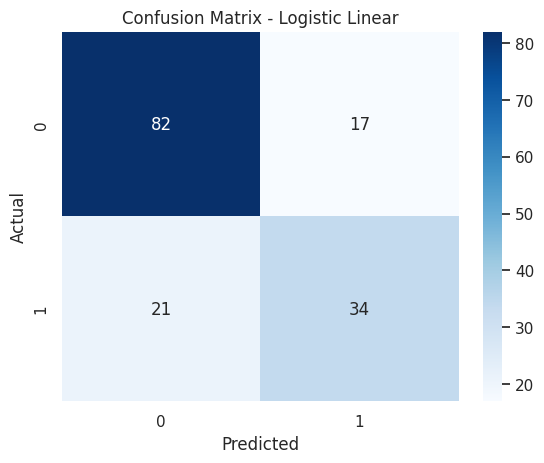

In [114]:
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Linear")
plt.show()

In [115]:
joblib.dump(model_lr, 'logistic_regression_model.h5')

['logistic_regression_model.h5']

## Random Forest

In [116]:
model_rf = RandomForestClassifier(n_estimators=50, max_depth=16, random_state=55, n_jobs=-1)
model_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=16, n_estimators=50, n_jobs=-1,
                       random_state=55)

In [135]:
y_pred_rf = model_rf.predict(X_test)

print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

[[80 19]
 [18 37]]
              precision    recall  f1-score   support

           0       0.82      0.81      0.81        99
           1       0.66      0.67      0.67        55

    accuracy                           0.76       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.76      0.76      0.76       154

Accuracy: 0.7597402597402597


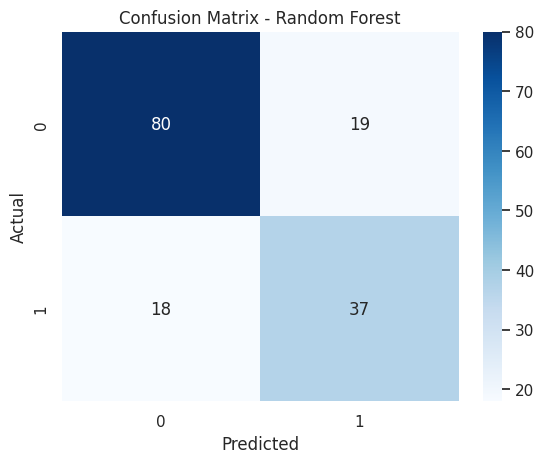

In [118]:
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [119]:
joblib.dump(model_rf, 'explore_random_forest_classification.h5')

['explore_random_forest_classification.h5']

## Hyperparameter Tuning Model

In [120]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [121]:
model_rf2 = RandomForestClassifier(random_state=42, class_weight='balanced')

In [122]:
grid_search = GridSearchCV(estimator=model_rf2, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='accuracy', verbose=1)

In [123]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 3, 5, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy', verbose=1)

In [124]:
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Best score: 0.7785419165667067


In [125]:
model_best_rf = grid_search.best_estimator_

In [126]:
y_pred_best = model_best_rf.predict(X_test)

print(classification_report(y_test, y_pred_best))
print("Final Accuracy with Best Params:", accuracy_score(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.85      0.74      0.79        99
           1       0.62      0.76      0.68        55

    accuracy                           0.75       154
   macro avg       0.73      0.75      0.74       154
weighted avg       0.77      0.75      0.75       154

Final Accuracy with Best Params: 0.7467532467532467


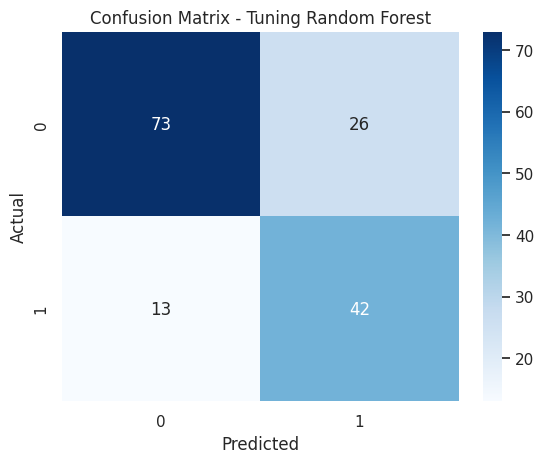

In [127]:
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Tuning Random Forest")
plt.show()

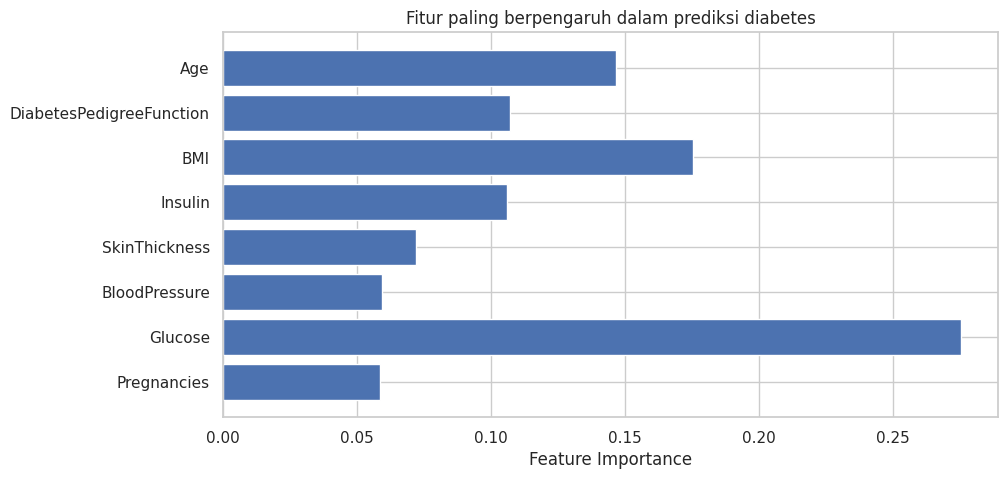

In [128]:
importances = model_best_rf.feature_importances_
feat_names = X.columns

plt.figure(figsize=(10,5))
plt.barh(feat_names, importances)
plt.xlabel("Feature Importance")
plt.title("Fitur paling berpengaruh dalam prediksi diabetes")
plt.show()

In [129]:
joblib.dump(model_best_rf, 'tuning_classification_rf.h5')

['tuning_classification_rf.h5']

## Boosting Algoritma

In [130]:
model_boost = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model_boost.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:15:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [137]:
y_pred_boost = model_boost.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_boost))
print("\nClassification Report:\n", classification_report(y_test, y_pred_boost))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_boost))

Accuracy: 0.7597402597402597

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81        99
           1       0.65      0.71      0.68        55

    accuracy                           0.76       154
   macro avg       0.74      0.75      0.74       154
weighted avg       0.77      0.76      0.76       154


Confusion Matrix:
 [[78 21]
 [16 39]]


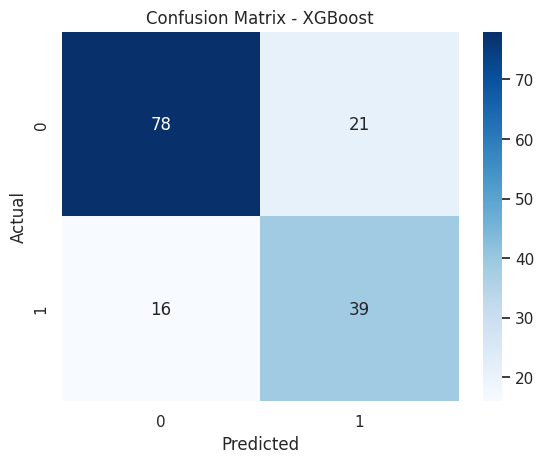

In [132]:
cm = confusion_matrix(y_test, y_pred_boost)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

In [133]:
eval_df = pd.DataFrame(index=['accuracy', 'f1'], columns=['Logistic Regression', 'Random Forest', 'XGBoost'])

eval_df.loc['accuracy', 'Logistic Regression'] = accuracy_score(y_test, model_lr.predict(X_test))
eval_df.loc['f1', 'Logistic Regression'] = f1_score(y_test, model_lr.predict(X_test))

eval_df.loc['accuracy', 'Random Forest'] = accuracy_score(y_test, model_rf.predict(X_test))
eval_df.loc['f1', 'Random Forest'] = f1_score(y_test, model_rf.predict(X_test))

eval_df.loc['accuracy', 'XGBoost'] = accuracy_score(y_test, y_pred_boost)
eval_df.loc['f1', 'XGBoost'] = f1_score(y_test, y_pred_boost)

display(eval_df)

,Logistic Regression,Random Forest,XGBoost
accuracy,0.753247,0.75974,0.75974
f1,0.641509,0.666667,0.678261


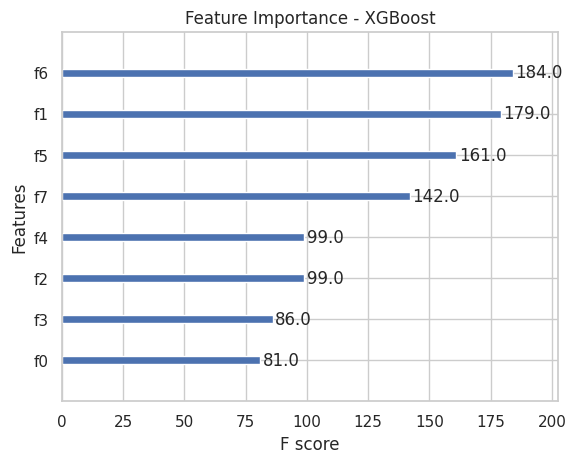

In [134]:
plot_importance(model_boost)
plt.title("Feature Importance - XGBoost")
plt.show()